In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from shapley.plots import set_style_paper, plot_sensitivity_results
set_style_paper()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [32]:
from shapley.tests import AdditiveGaussian, Ishigami
from shapley.tests.utils import true_gaussian_full_ind_sobol

Model = AdditiveGaussian

if Model == AdditiveGaussian:
    dim = 3
    beta = None
    model = Model(dim=dim, beta=beta)
    #model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
    theta = [0., 0., -0.5]
    true_full_indices, true_ind_indices = true_gaussian_full_ind_sobol(theta, dim=dim)
    true_indices = {'full': true_full_indices,
                    'ind': true_ind_indices}
    model.copula_parameters = theta
elif Model == Ishigami:
    model = Model()
    dim = model.dim
    model.copula = ot.NormalCopula(dim)
    theta = [0., 0., 0.]

In [33]:
%%time
from shapley import ShapleyIndices
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

shapley_method = 'random'

n_var = 1000
n_inner = 3
if shapley_method == 'exact':
    n_perms = None
    n_outer = 100
else:
    n_perms = 600
    n_outer = 1

budget_perms = np.math.factorial(dim) if n_perms is None else n_perms
max_budget = n_var + n_outer * n_inner * budget_perms * (dim - 1)
print('Max budget:', max_budget)

shapley = ShapleyIndices(model.input_distribution)
shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=n_outer, n_inner=n_inner)

Max budget: 4600
Wall time: 1.28 s


In [34]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 500
shapley_results = shapley.compute_indices(n_boot=n_boot)
shapley_results._shapley_indices = None

Wall time: 8.59 s


In [35]:
%%time
from shapley import SobolIndices

ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_sample = int(max_budget / (dim*4))

sobol = SobolIndices(model.input_distribution)
# Generate the samples
sobol.build_uncorr_sample(model=model, n_sample=n_sample)

Wall time: 13 ms


In [51]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)
all_sobol_results = {}

estimator = 'sobolmara'

for i, indice_type in enumerate(['full', 'ind']):    
    results = sobol.compute_indices(n_boot=n_boot, estimator=estimator, indice_type=indice_type)
    results.true_first_indices = true_indices[indice_type]
    results.true_total_indices = true_indices[indice_type]
    all_sobol_results[indice_type] = results

Wall time: 52.1 ms


In [52]:
sobol_results = all_sobol_results['full']
sobol_results.total_indices = all_sobol_results['ind']._total_indices
sobol_results.true_total_indices = true_indices['ind']

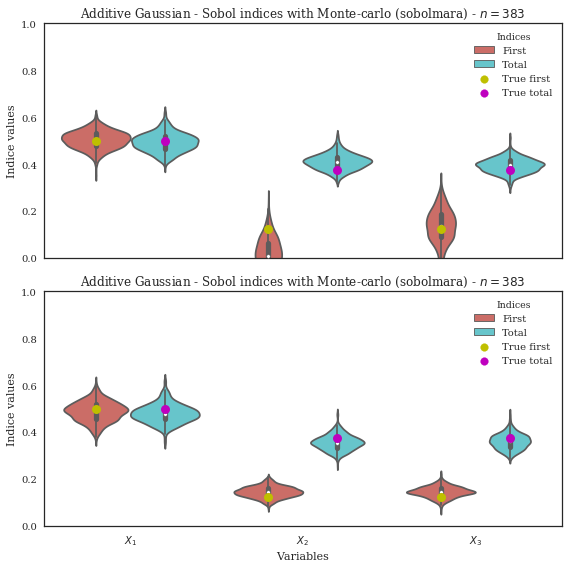

In [53]:
from shapley.plots import plot_sensitivity_results
ylim = [0., 1.]

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)
for i, results in enumerate([shapley_results, sobol_results]):
    ax = axes[i]
    plot_sensitivity_results(results, ax=ax)
    ax.set_title("%s - Sobol indices with Monte-carlo (%s) - $n=%d$" % (model.name, estimator, n_sample))
    ax.set_ylim(ylim)
    
axes[0].set_xlabel('')
fig.tight_layout()

In [39]:
for results in [shapley_results, sobol_results]:
    print(results.full_total_indices[:, 0] - results.true_total_indices)

[-0.00794578  0.03495462  0.02136216]
[-0.02390562 -0.02119593 -0.01868466]


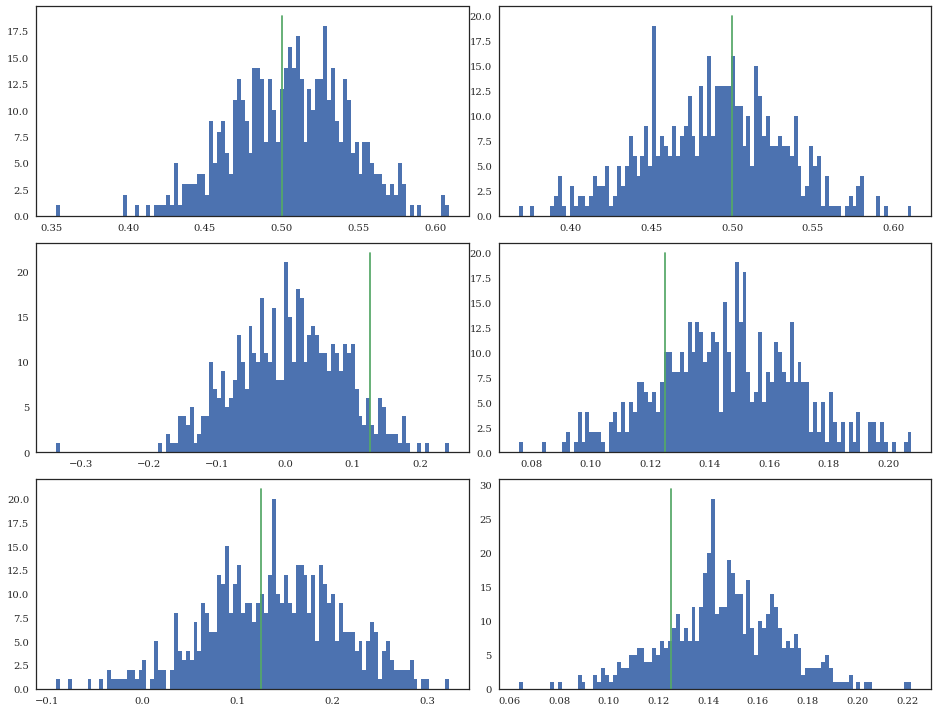

In [41]:
fig, axes = plt.subplots(dim, 2, figsize=(13, 10))
for i in range(dim):
    for j, results in enumerate([shapley_results, sobol_results]):
        ax = axes[i, j]
        ax.hist(results.full_first_indices[i, 1:], bins=100); 
        ax.plot([results.true_first_indices[i]]*2, ax.get_ylim())
fig.tight_layout()